In this project, I am going to develop an NLP model to predict students'potential math misconceptions based on their explanations of open ended responses. This will help teachers to identify easily and address students'incorrect thinking and certainly improve students math learning.

I am going to use the DeBERTa v3 base model, because our dataset is medium_sized, and it efficiently captures word meaning and position with strong performance.

## Importing Libraries:

In [1]:

import pandas as pd, numpy as np
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import AutoTokenizer
import torch
from transformers import TrainingArguments, Trainer
from transformers import AutoModelForSequenceClassification
#from transformers import DebertaV2ForSequenceClassification
from sklearn.metrics import average_precision_score
import joblib
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

2025-08-23 22:16:55.924032: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755987416.250321      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755987416.348148      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/huggingfacedebertav3variants/khalidalt-DeBERTa-v3-large/spm.model
/kaggle/input/huggingfacedebertav3variants/khalidalt-DeBERTa-v3-large/config.json
/kaggle/input/huggingfacedebertav3variants/khalidalt-DeBERTa-v3-large/README (1).md
/kaggle/input/huggingfacedebertav3variants/khalidalt-DeBERTa-v3-large/README.md
/kaggle/input/huggingfacedebertav3variants/khalidalt-DeBERTa-v3-large/tokenizer_config.json
/kaggle/input/huggingfacedebertav3variants/khalidalt-DeBERTa-v3-large/tokenizer_config (1).json
/kaggle/input/huggingfacedebertav3variants/khalidalt-DeBERTa-v3-large/pytorch_model.bin
/kaggle/input/huggingfacedebertav3variants/khalidalt-DeBERTa-v3-large/special_tokens_map.json
/kaggle/input/huggingfacedebertav3variants/khalidalt-DeBERTa-v3-large/gitattributes.txt
/kaggle/input/huggingfacedebertav3variants/khalidalt-DeBERTa-v3-large/added_tokens.json
/kaggle/input/huggingfacedebertav3variants/deberta-v3-base-squad2/spm.model
/kaggle/input/huggingfacedebertav3variants/deberta-v

## Environment and Run Configuration:

In [2]:
# set the CUDA environment variable
os.environ["CUDA_VISIBLE_DEVICES"]= "0,1"
# set the version number for the model run
VER=1
# model name & path
model_name= "microsoft/deberta-v3-base"
model_path = "/kaggle/input/huggingfacedebertav3variants/deberta-v3-base"

# number of epochs to train the model
EPOCHS = 6
# create a directory name to save model weights, logs, submission files
DIR = f"ver-{VER}"
# creates the folder if it doesn't exist
os.makedirs(DIR, exist_ok=True)

## Loading Data:

In [3]:
# Load training & test set
train = pd.read_csv('/kaggle/input/map-charting-student-math-misunderstandings/train.csv')
test = pd.read_csv("/kaggle/input/map-charting-student-math-misunderstandings/test.csv")

# display the shape 
print(f"Training set: {train.shape}")
print(f"Test set: {test.shape}")
# first rows
print(train.head())

Training set: (36696, 7)
Test set: (3, 5)
   row_id  QuestionId                                       QuestionText  \
0       0       31772  What fraction of the shape is not shaded? Give...   
1       1       31772  What fraction of the shape is not shaded? Give...   
2       2       31772  What fraction of the shape is not shaded? Give...   
3       3       31772  What fraction of the shape is not shaded? Give...   
4       4       31772  What fraction of the shape is not shaded? Give...   

           MC_Answer                                 StudentExplanation  \
0  \( \frac{1}{3} \)                  0ne third is equal to tree nineth   
1  \( \frac{1}{3} \)  1 / 3 because 6 over 9 is 2 thirds and 1 third...   
2  \( \frac{1}{3} \)  1 3rd is half of 3 6th, so it is simplee to un...   
3  \( \frac{1}{3} \)        1 goes into everything and 3 goes into nine   
4  \( \frac{1}{3} \)                    1 out of every 3 isn't coloured   

       Category Misconception  
0  True_Correct   

In [4]:
# overview of data:
print("\nTrain:")
train.info()
print("\nTest:")
test.info()



Train:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36696 entries, 0 to 36695
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   row_id              36696 non-null  int64 
 1   QuestionId          36696 non-null  int64 
 2   QuestionText        36696 non-null  object
 3   MC_Answer           36696 non-null  object
 4   StudentExplanation  36696 non-null  object
 5   Category            36696 non-null  object
 6   Misconception       9860 non-null   object
dtypes: int64(2), object(5)
memory usage: 2.0+ MB

Test:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   row_id              3 non-null      int64 
 1   QuestionId          3 non-null      int64 
 2   QuestionText        3 non-null      object
 3   MC_Answer           3 non-null      object
 4   St

## Data Preprocessing

### - Handling Missing data in "Misconception" column:

In [5]:
# The column 'Misconception' includes NaN. We can't drop these rows, We fill them with 'NA'
train.Misconception = train.Misconception.fillna('NA')


### - Label Encoding:

In [6]:
# # define the target
train['target'] = train.Category+":"+train.Misconception
# Label encoding the target
le = LabelEncoder()
train['label'] = le.fit_transform(train['target'])
# display the number of classes of the target
n_classes = len(le.classes_)
print (n_classes)

65


### - Creating new features:

- Create a new column 'is_correct' to mark the correct answers:

In [7]:
# apply a function to each row in train to split Category, take 1st part & check if it is equal to 'True'
idx = train.apply(lambda row: row['Category'].split('_')[0], axis=1)=='True'
idx.head()

0    True
1    True
2    True
3    True
4    True
dtype: bool

In [8]:
# create a copy of the train rows and columns where the category being with True through the booleen array (idx) 
correct = train.loc[idx].copy()
# count how many times each pair (QuestionID, MC_Answer) appears in the correct answers and sort them in descending order
correct['c'] = correct.groupby(['QuestionId','MC_Answer']).MC_Answer.transform('count')
correct = correct.sort_values('c',ascending=False)
# drop duplicates to keep only first row based on QuestionID
correct = correct.drop_duplicates(['QuestionId'])
# reduce the table correct to the necessary fields for merging
correct = correct[['QuestionId','MC_Answer']]
# create a new column 'is_correct' set it to 1 to mark the answers as correct
correct['is_correct'] = 1
correct.head()

,QuestionId,MC_Answer,is_correct
61,31772,\( \frac{1}{3} \),1
7430,31774,\( \frac{1}{12} \),1
10770,31777,\( 72 \),1
14266,31778,\( 6 \),1
14440,32829,\( 12 \),1


In [9]:
# merge correct table with train set on the columns 'QuestionID' and 'AC_Answer'
train = train.merge(correct, on =['QuestionId','MC_Answer'],how='left' )
train.is_correct = train.is_correct.fillna(0)
train.head()

,row_id,QuestionId,QuestionText,MC_Answer,StudentExplanation,Category,Misconception,target,label,is_correct
0,0,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),0ne third is equal to tree nineth,True_Correct,NA,True_Correct:NA,37,1.0
1,1,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 / 3 because 6 over 9 is 2 thirds and 1 third...,True_Correct,NA,True_Correct:NA,37,1.0
2,2,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),"1 3rd is half of 3 6th, so it is simplee to un...",True_Neither,NA,True_Neither:NA,64,1.0
3,3,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 goes into everything and 3 goes into nine,True_Neither,NA,True_Neither:NA,64,1.0
4,4,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 out of every 3 isn't coloured,True_Correct,NA,True_Correct:NA,37,1.0


- Create the 'text' column including Question, Answer, explanation and if it 'is correct' or not:

In [10]:
# format the input text which we will tokenize
def format_input(row):
    x = "This answer is correct."
    if not row['is_correct']:
        x = "This is answer is incorrect."
    return (
        f" Question: {row['QuestionText']}\n"
        f" Answer: {row['MC_Answer']}\n"
        f" {x}\n"
        f"Student Explanation: {row['StudentExplanation']}"
    )

train['text'] = train.apply(format_input,axis=1)
print("Example prompt for our LLM:")
print()
print( train.text[0])


Example prompt for our LLM:

 Question: What fraction of the shape is not shaded? Give your answer in its simplest form. [Image: A triangle split into 9 equal smaller triangles. 6 of them are shaded.]
 Answer: \( \frac{1}{3} \)
 This answer is correct.
Student Explanation: 0ne third is equal to tree nineth


/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


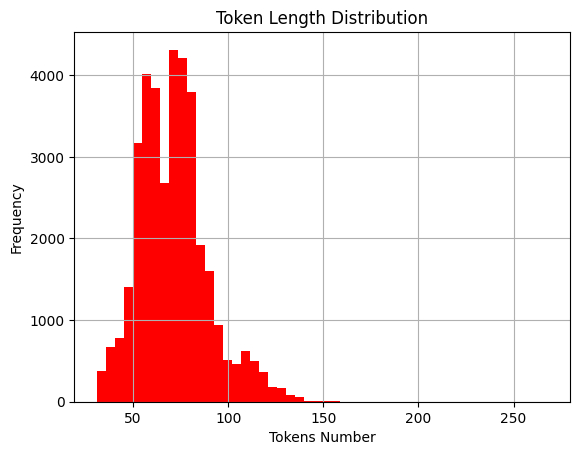

In [11]:
# compute the lenghts of tokens in the 'text' column
tokenizer = AutoTokenizer.from_pretrained(model_path, local_files_only=True)
MAX_LEN = 256
lengths = [len(tokenizer.encode(t, truncation=False)) for t in train["text"]]

# visualize the tokens' lenghts
import matplotlib.pyplot as plt
plt.hist(lengths, bins=50, color='r')
plt.title("Token Length Distribution")
plt.xlabel("Tokens Number")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [12]:
# display the number of train samples more than max lenght (256).

L = (np.array(lengths)>MAX_LEN).sum()
print(f"There are {L} train sample(s) with more than {MAX_LEN} tokens")
np.sort( lengths )

There are 1 train sample(s) with more than 256 tokens


array([ 31,  31,  31, ..., 184, 231, 268])

### - Splitting data into training and validation sets:

In [13]:
train_df, val_df = train_test_split(train, test_size=0.2, random_state=42)

### - Converting to Hugging Face datasets: 


In [14]:
columns = ['text', 'label']
train_ds = Dataset.from_pandas(train_df[columns])
val_ds = Dataset.from_pandas(train_df[columns])


### - Data Tokenization (Training & Validation Hugging Face datasets):

In [15]:
# create Tokenization function
def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=256)
# tokenize training and validation hugging face datasets
train_ds = train_ds.map(tokenize, batched=True)
val_ds = val_ds.map(tokenize, batched=True)

Map:   0%|          | 0/29356 [00:00<?, ? examples/s]

Map:   0%|          | 0/29356 [00:00<?, ? examples/s]

In [16]:
# Set format for PyTorch
columns = ['input_ids', 'attention_mask', 'label']
train_ds.set_format(type='torch', columns=columns)
val_ds.set_format(type='torch', columns=columns)

# check the format transformation: 
sample =train_ds[0]
{col:type(val) for col, val in sample.items()}


{'label': torch.Tensor,
 'input_ids': torch.Tensor,
 'attention_mask': torch.Tensor}

## Model Training and Evaluation:

### - Model building:

In [17]:
# set up model
model = AutoModelForSequenceClassification.from_pretrained(model_path, local_files_only=True, num_labels=n_classes,
    ignore_mismatched_sizes=True)


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/huggingfacedebertav3variants/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
# setting up training arguments
training_args = TrainingArguments(
    output_dir = f"./{DIR}",
    do_train=True,
    do_eval=True,
    eval_strategy="steps",
    save_strategy="steps", 
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=5e-5,
    logging_dir="./logs",
    logging_steps=50,
    save_steps=200,
    eval_steps=200,
    save_total_limit=1, # keep only the most recent checkpoint
    metric_for_best_model="map@3",
    greater_is_better=True,
    load_best_model_at_end=True,
    report_to="none",
)

We will evaluate our model every 200 steps, log every 50 steps and decide which is the best model based on the metric "map@3".

In [19]:
# Compute MAP@3 metric

def compute_map3(eval_pred):
    logits, labels = eval_pred # unpack eval_pred
    # convert logits into pytorch tensor, apply softmax to get prob for each class, then convert to numpy array
    probs = torch.nn.functional.softmax(torch.tensor(logits), dim=-1).numpy()
    # sort indices in ascend order and flips it to get the three top predicted class indices per row
    top3 = np.argsort(-probs, axis=1)[:, :3]  # Top 3 predictions per row
    # compare each label to the three predictions for that row
    match = (top3 == labels[:, None])

    # Compute MAP@3 manually
    map3 = 0
    for i in range(len(labels)):
        if match[i, 0]:
            map3 += 1.0
        elif match[i, 1]:
            map3 += 1.0 / 2
        elif match[i, 2]:
            map3 += 1.0 / 3
    return {"map@3": map3 / len(labels)}

### - Training and Saving Model:

In [20]:
# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_map3,
)

trainer.train()

/tmp/ipykernel_19/2123443610.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Map@3
200,1.358900,1.414440,0.693033
400,0.957700,0.905942,0.810209
600,0.847300,0.805150,0.842179
800,0.714900,0.627037,0.874796
1000,0.651300,0.608919,0.880013
1200,0.566900,0.523203,0.898947
1400,0.522400,0.501758,0.900605
1600,0.538000,0.494180,0.902899
1800,0.530200,0.469121,0.909377
2000,0.481500,0.448183,0.910632


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

TrainOutput(global_step=5508, training_loss=0.4962214149031504, metrics={'train_runtime': 13875.837, 'train_samples_per_second': 12.694, 'train_steps_per_second': 0.397, 'total_flos': 2.318518706898125e+16, 'train_loss': 0.4962214149031504, 'epoch': 6.0})

In [21]:
# Save model

trainer.save_model(f"{DIR}/best")
_ = joblib.dump(le, f"{DIR}/label_encoder.joblib")


In [22]:
tokenizer = AutoTokenizer.from_pretrained(f"{DIR}/best") 
model = AutoModelForSequenceClassification.from_pretrained(
    f"{DIR}/best",
    num_labels=n_classes  
)
training_args = TrainingArguments(report_to="none")
trainer = Trainer(model=model, tokenizer=tokenizer, args=training_args)
le = joblib.load(f"{DIR}/label_encoder.joblib")

/tmp/ipykernel_19/3235029901.py:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, tokenizer=tokenizer, args=training_args)


### - Predictions and Saving Submission file:

In [23]:
test = test.merge(correct, on=['QuestionId','MC_Answer'], how='left')
test.is_correct = test.is_correct.fillna(0)

test['text'] = test.apply(format_input,axis=1)

test.head()

,row_id,QuestionId,QuestionText,MC_Answer,StudentExplanation,is_correct,text
0,36696,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),"I think that 1/3 is the answer, as it's the si...",1.0,Question: What fraction of the shape is not s...
1,36697,31772,What fraction of the shape is not shaded? Give...,\( \frac{3}{6} \),i think this answer is because 3 triangles are...,0.0,Question: What fraction of the shape is not s...
2,36698,32835,Which number is the greatest?,\( 6.2 \),because the 2 makes it higher than the others.,1.0,Question: Which number is the greatest?\n Ans...


In [24]:
ds_test = Dataset.from_pandas(test[['text']])
ds_test = ds_test.map(tokenize, batched=True)

predictions = trainer.predict(ds_test)
probs = torch.nn.functional.softmax(torch.tensor(predictions.predictions), dim=1).numpy()

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

In [25]:
# Get top 3 predicted class indices
top3 = np.argsort(-probs, axis=1)[:, :3]   # shape: [num_samples, 3]

# Decode numeric class indices to original string labels
flat_top3 = top3.flatten()
decoded_labels = le.inverse_transform(flat_top3)
top3_labels = decoded_labels.reshape(top3.shape)

# Join 3 labels per row with space
joined_preds = [" ".join(row) for row in top3_labels]

# Save submission
submission = pd.DataFrame({
    "row_id": test.row_id.values,
    "Category:Misconception": joined_preds
})
submission.to_csv("/kaggle/working/submission.csv", index=False)
submission.head()

,row_id,Category:Misconception
0,36696,True_Correct:NA True_Neither:NA True_Misconcep...
1,36697,False_Misconception:WNB False_Neither:NA False...
2,36698,True_Neither:NA True_Correct:NA True_Misconcep...


In [26]:
import os
os.path.exists("/kaggle/working/submission.csv")

True